[View in Colaboratory](https://colab.research.google.com/github/sharathsrini/Extended-Kalman-Filter-for-Sensor-Fusion/blob/master/d.ipynb)

In [0]:
from math import inf

def dijkstra(grid, src, dest):
    Q = grid.get_nodes()
    dist = {node : inf for node in Q}
    prev = {node : None for node in Q}

    dist[src] = 0

    while Q:
        u = min(Q, key = dist.__getitem__)
        Q.remove(u)

        for v in grid.get_adjacent(u):
            alt = dist[u] + 1
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u

    path = [dest]
    cur = dest

    while prev[cur]:
        path.append(prev[cur])
        cur = prev[cur]

    return list(reversed(path))

In [0]:
from itertools import product

class Grid(object):

    def __init__(self, i, j, obstacles = []):
        self.i = i
        self.j = j
        self.grid = [[0] * i for _ in range(j)]

        self.obstacles = obstacles

        for obstacle in obstacles:
            self.grid[obstacle[0]][obstacle[1]] = 1

    def __str__(self):
        return "\n".join("".join(x) for x in self.char_map())

    def __repr__(self):
        return "{} by {} grid:\n".format(self.i, self.j) + self.__str__()

    def char_map(self):
        arr = [["0"] * self.j for _ in range(self.i)]

        for obstacle in self.obstacles:
            arr[obstacle[0]][obstacle[1]] = "1"

        return arr

    def get_adjacent(self, node):
        i = node[0]
        j = node[1]

        if i < 0 or i >= self.i or j < 0 or j >= self.j:
            raise Exception("Out of bounds")

        if self.grid[i][j] != 0:
            return []

        adjacent = []

        for del_pos in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
            if 0 <= i + del_pos[0] < self.j and 0 <= j + del_pos[1] < self.j:
                if self.grid[i + del_pos[0]][j + del_pos[1]] == 0:
                    adjacent.append((i + del_pos[0], j + del_pos[1]))

        return adjacent

    def get_nodes(self):
        return [(i, j) for i, j in product(range(self.i), range(self.j)) if (i, j) not in self.obstacles]

    def plot_path(self, path):
        arr = self.char_map()
        for node in path:
            arr[node[0]][node[1]] = "."

        return "\n".join("".join(x) for x in arr)

In [19]:
g = Grid(20, 20, obstacles = [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)])
src = (0, 0)
dest = (20, 19)

print("Grid visualization: ")
print(g)

Grid visualization: 
00000000000000000000
00000000000000000000
11111000000000000000
00000000000000000000
00111110000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000
00000000000000000000


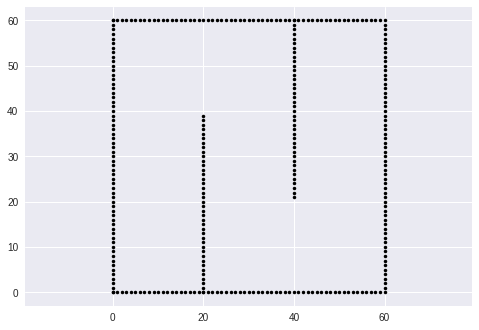

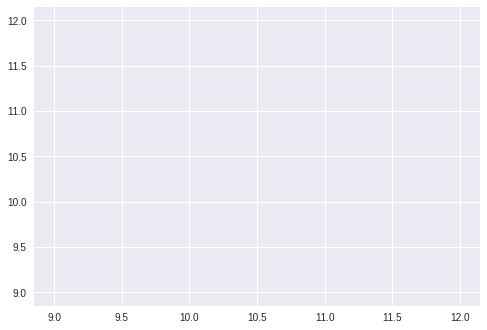

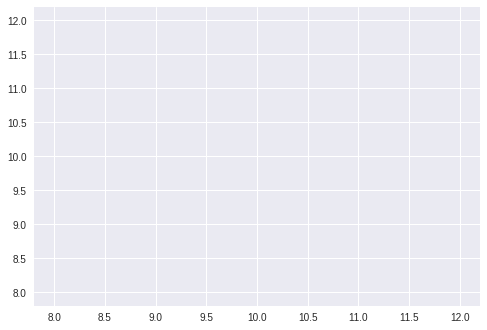

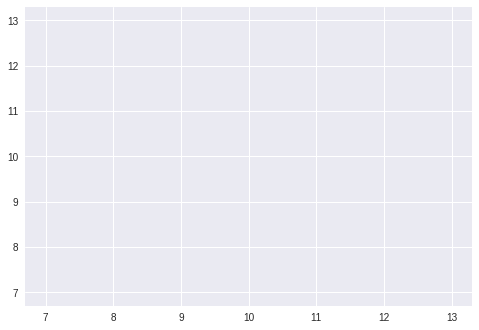

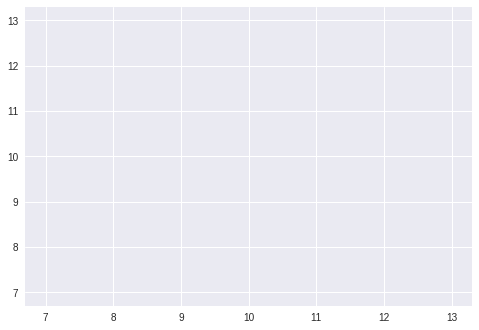

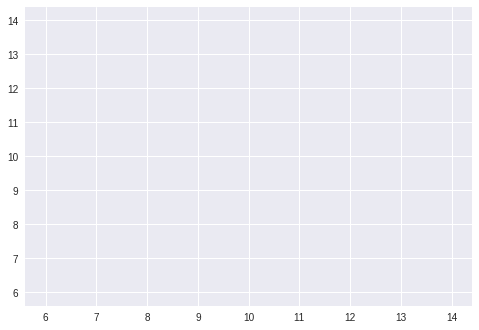

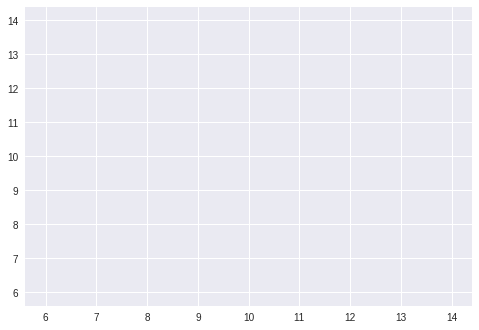

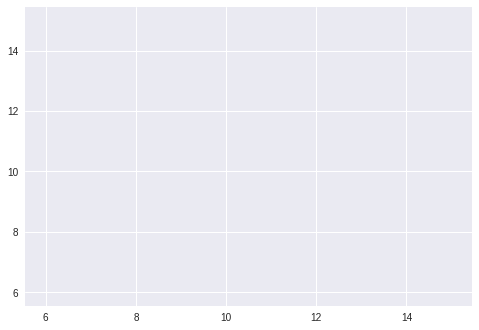

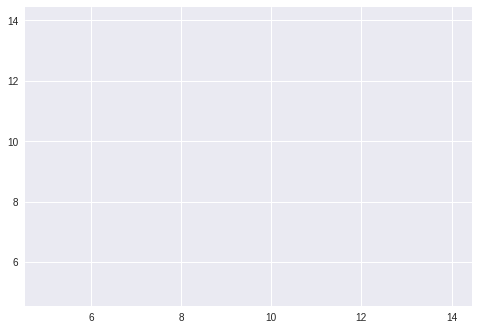

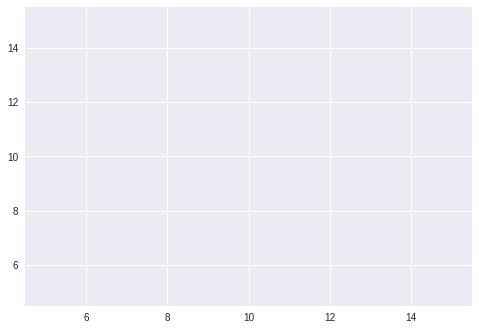

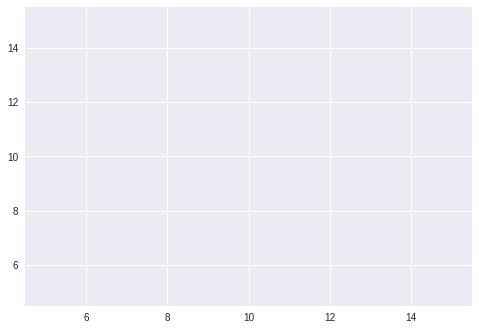

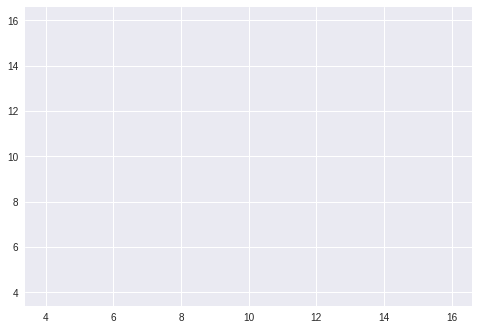

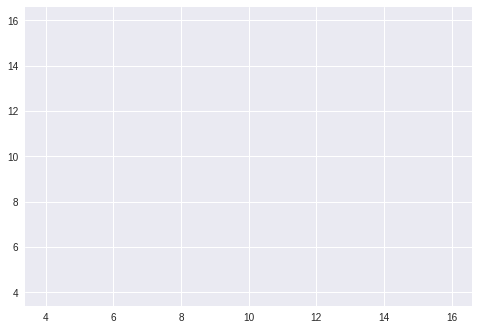

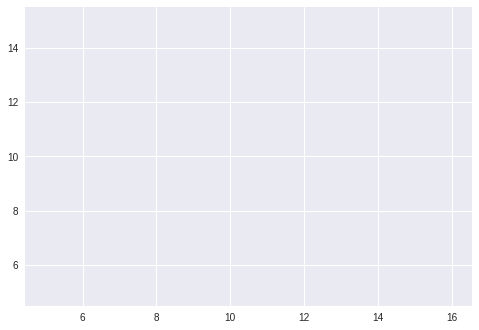

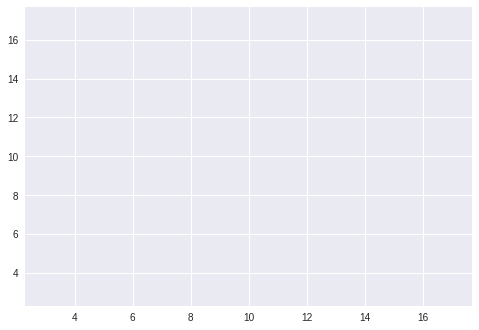

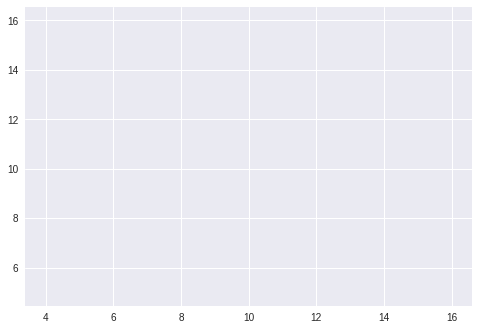

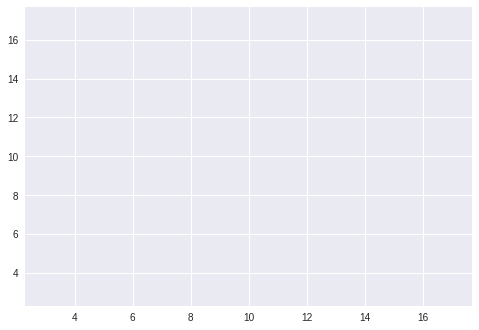

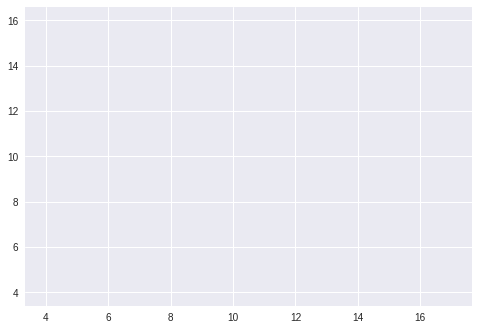

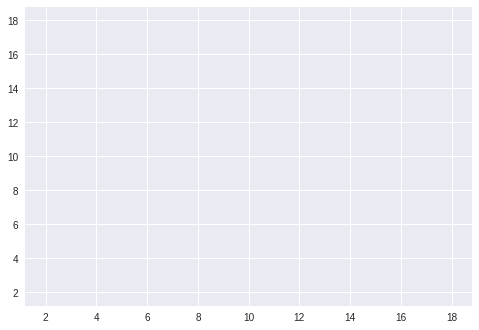

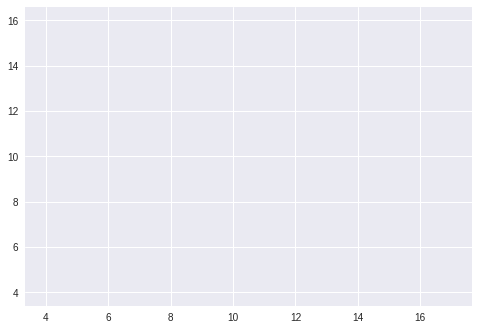

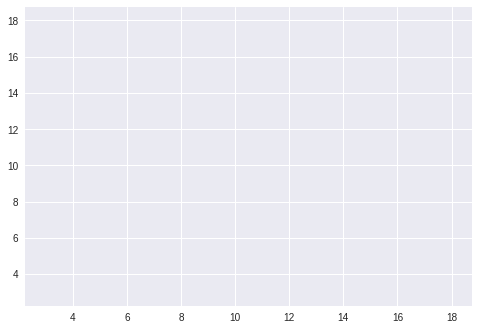

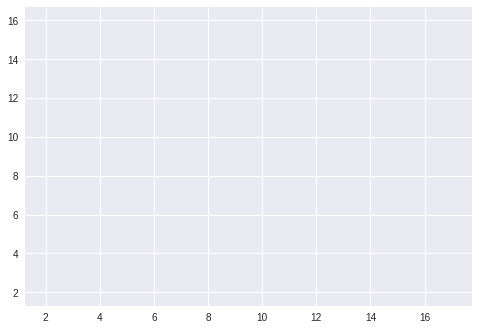

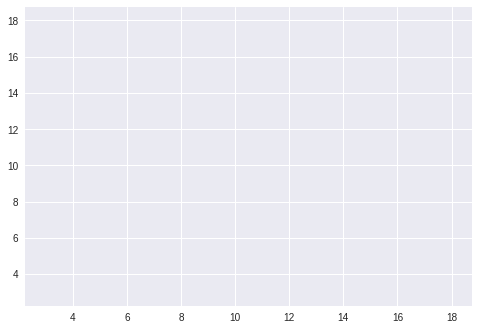

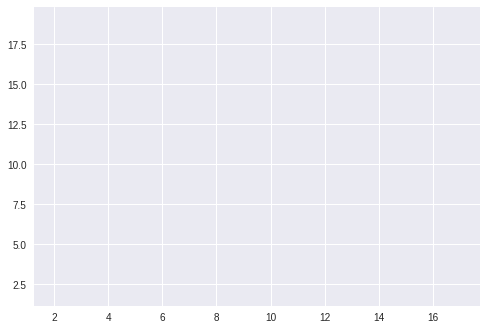

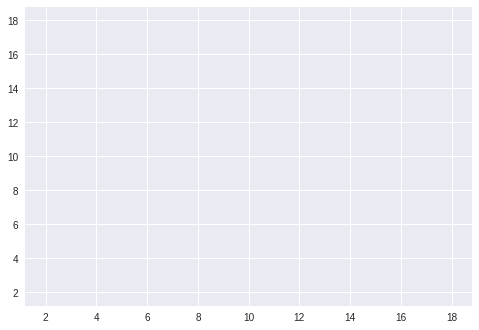

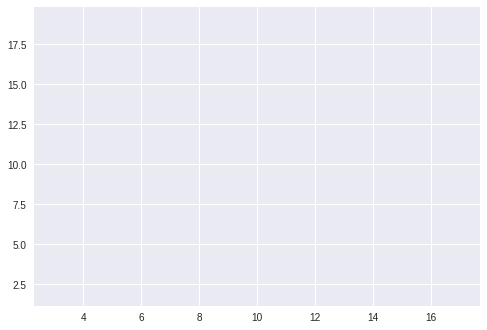

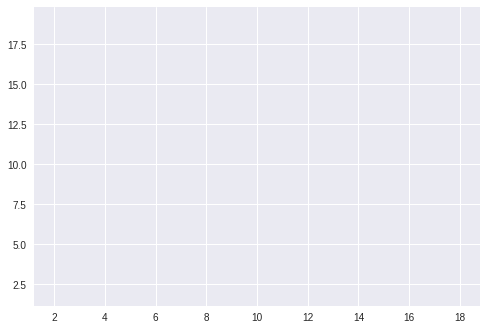

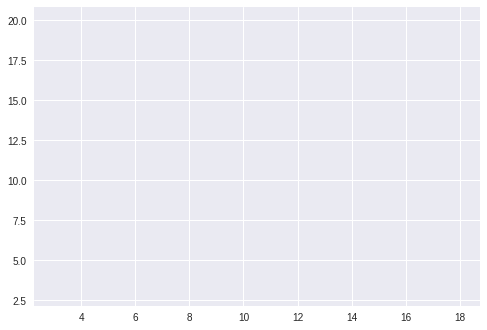

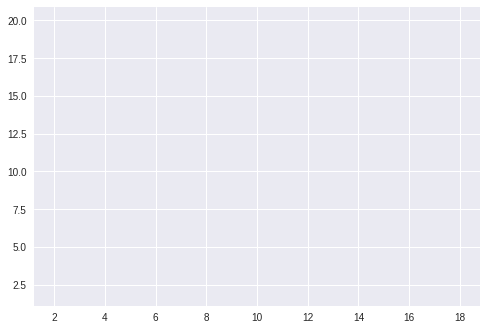

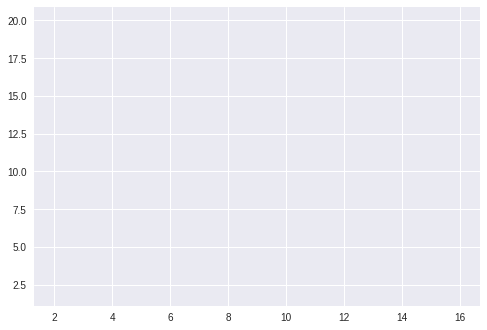

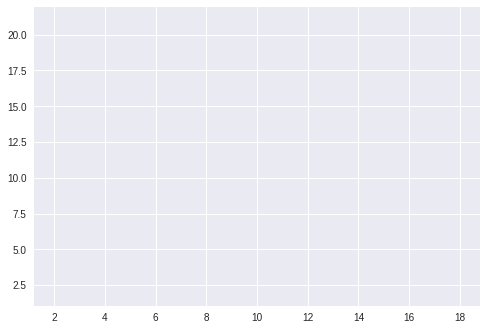

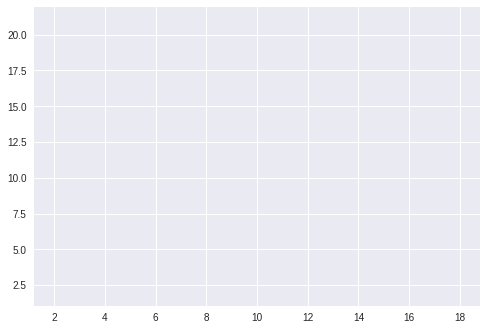

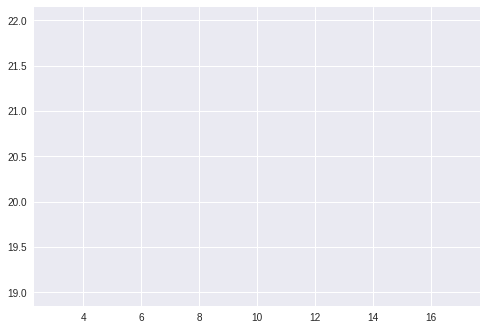

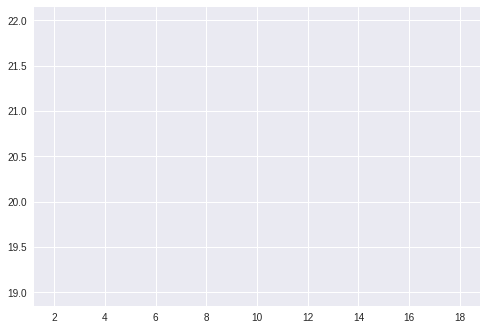

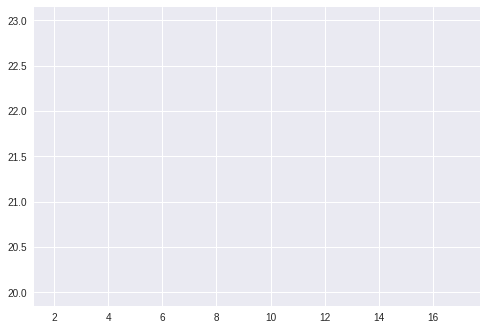

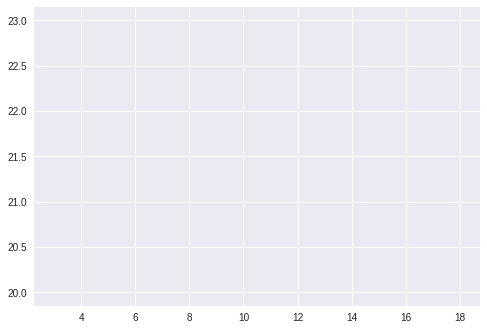

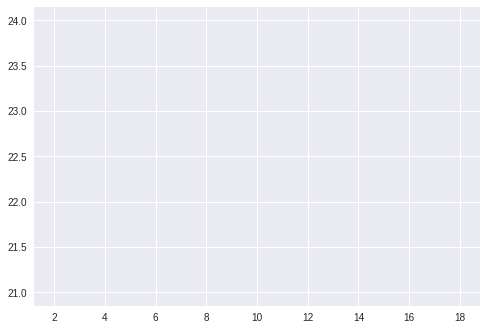

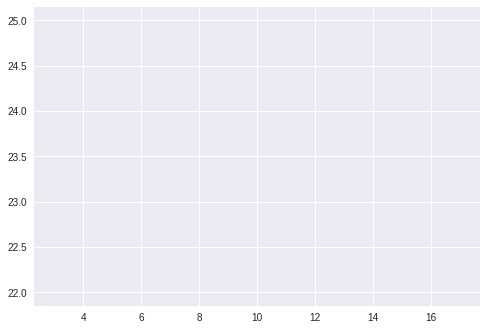

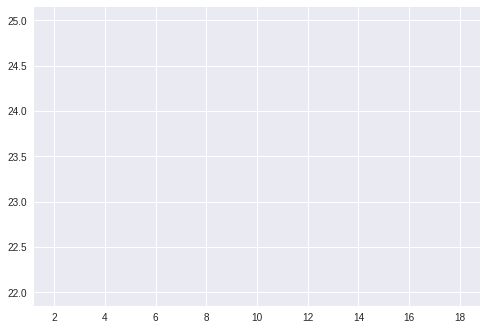

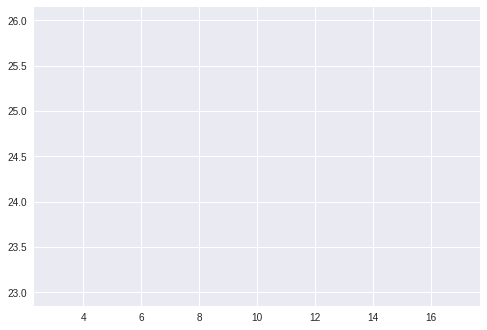

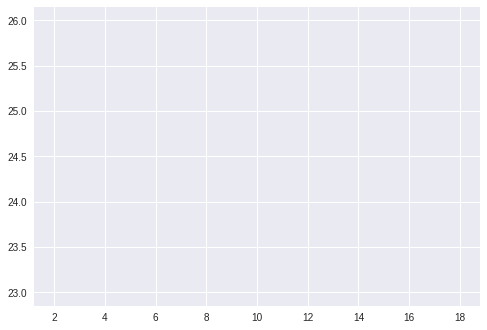

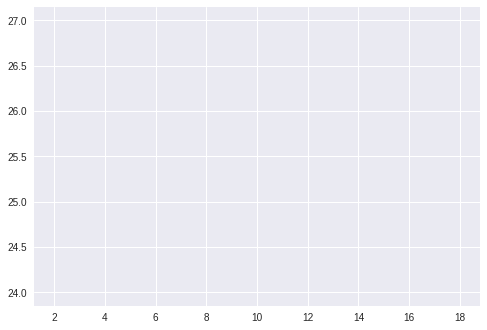

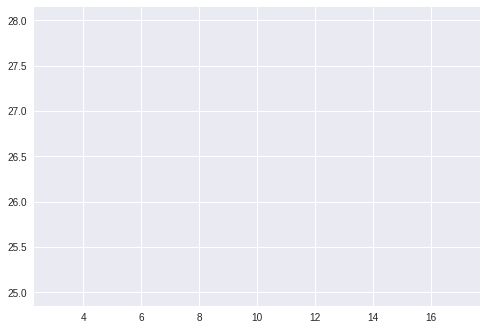

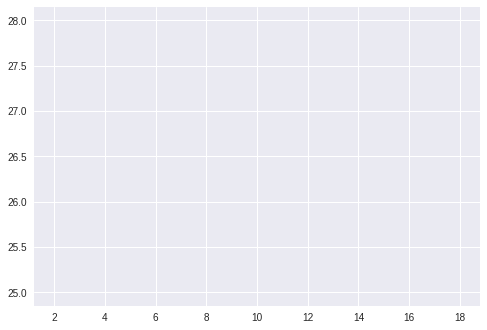

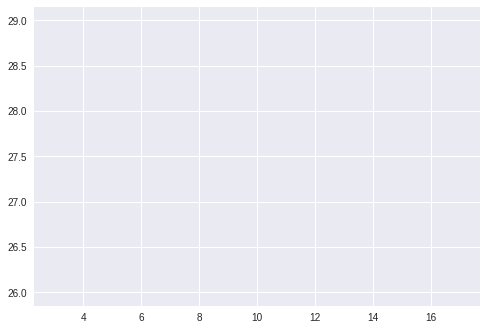

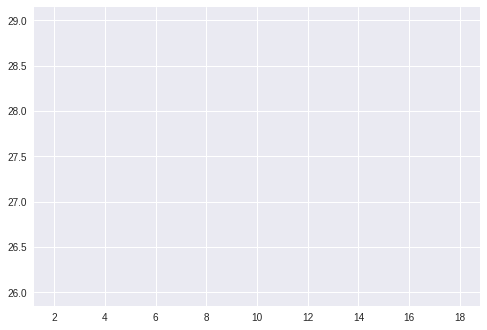

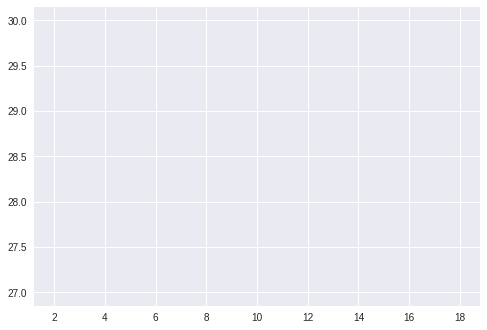

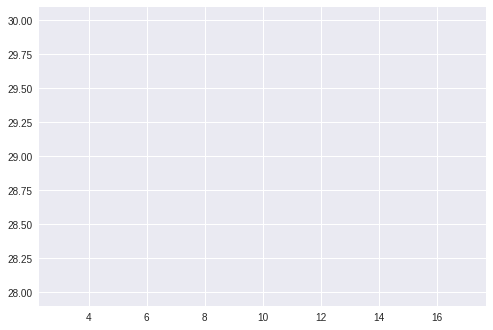

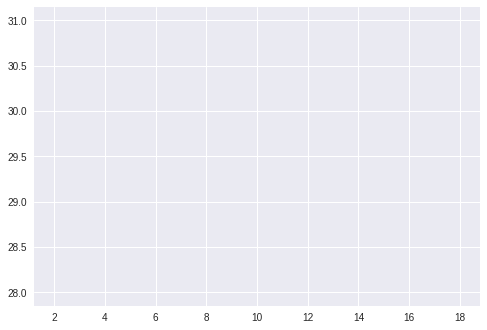

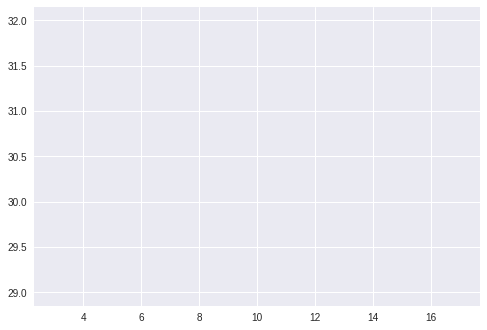

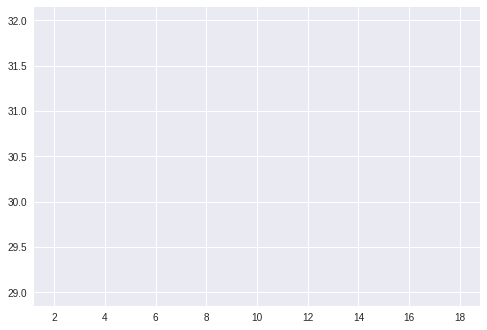

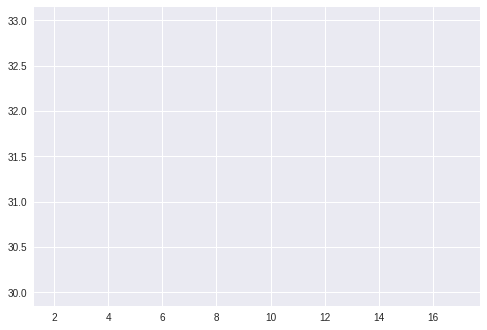

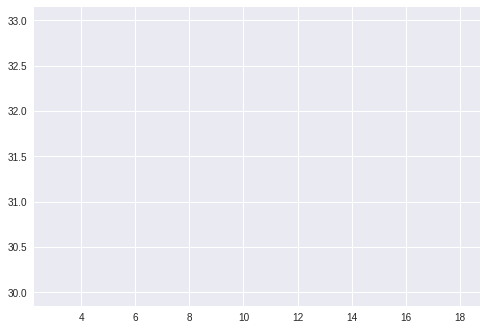

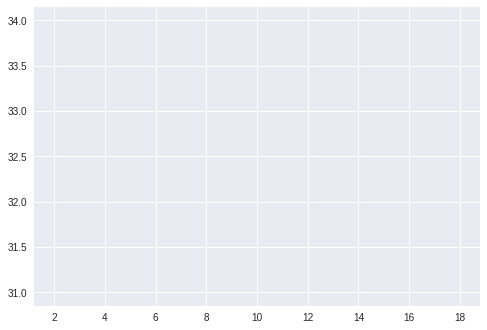

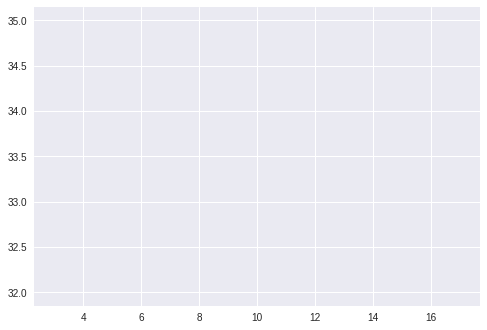

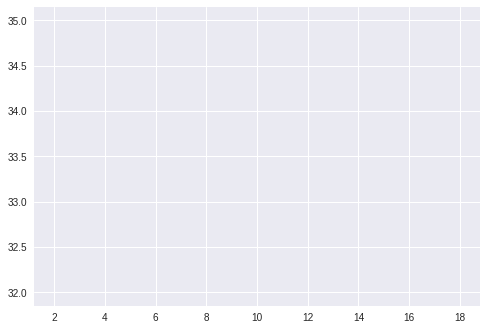

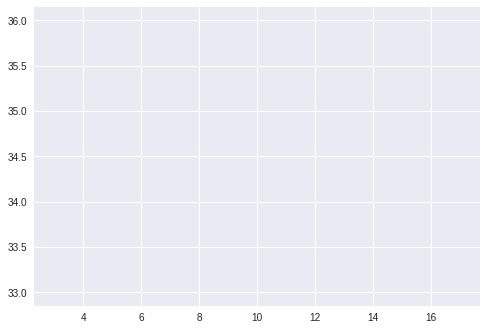

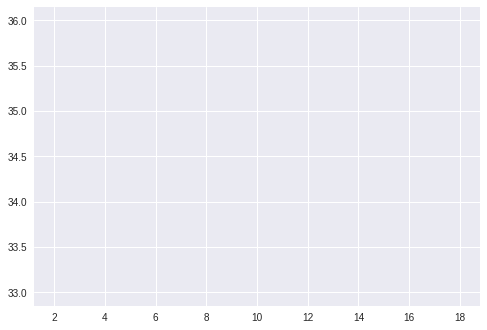

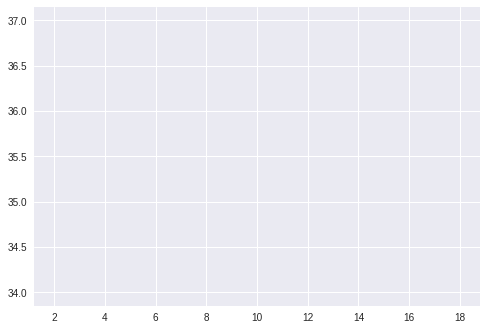

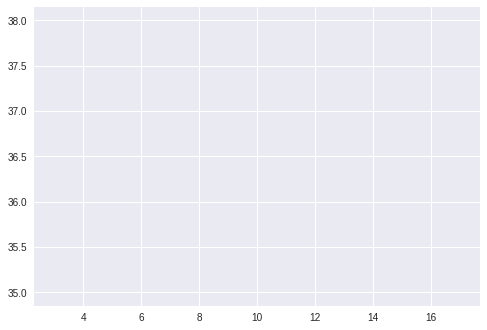

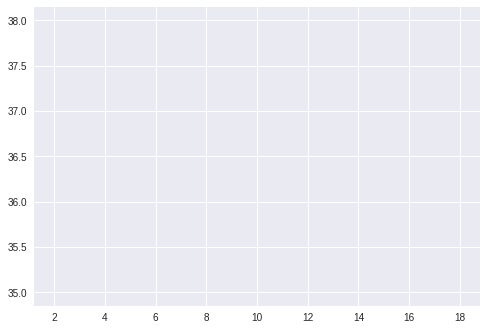

IndexError: ignored

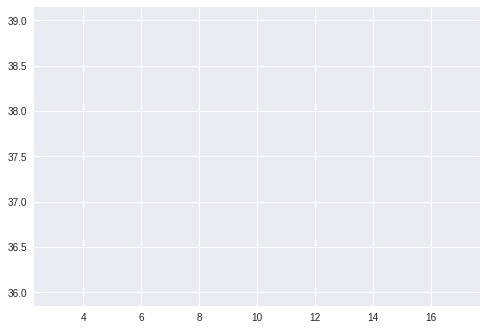

In [23]:
import matplotlib.pyplot as plt
import math

show_animation = True


class Node:

    def __init__(self, x, y, cost, pind):
        self.x = x
        self.y = y
        self.cost = cost
        self.pind = pind

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.pind)


def dijkstra_planning(sx, sy, gx, gy, ox, oy, reso, rr):
    """
    gx: goal x position [m]
    gx: goal x position [m]
    ox: x position list of Obstacles [m]
    oy: y position list of Obstacles [m]
    reso: grid resolution [m]
    rr: robot radius[m]
    """

    nstart = Node(round(sx / reso), round(sy / reso), 0.0, -1)
    ngoal = Node(round(gx / reso), round(gy / reso), 0.0, -1)
    ox = [iox / reso for iox in ox]
    oy = [ioy / reso for ioy in oy]

    obmap, minx, miny, maxx, maxy, xw, yw = calc_obstacle_map(ox, oy, reso, rr)

    motion = get_motion_model()

    openset, closedset = dict(), dict()
    openset[calc_index(nstart, xw, minx, miny)] = nstart

    while 1:
        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]
        #  print("current", current)

        # show graph
        if show_animation:
            plt.plot(current.x * reso, current.y * reso, "xc")
            if len(closedset.keys()) % 10 == 0:
                plt.pause(0.001)

        if current.x == ngoal.x and current.y == ngoal.y:
            print("Find goal")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        for i in range(len(motion)):
            node = Node(current.x + motion[i][0], current.y + motion[i][1],
                        current.cost + motion[i][2], c_id)
            n_id = calc_index(node, xw, minx, miny)

            if not verify_node(node, obmap, minx, miny, maxx, maxy):
                continue

            if n_id in closedset:
                continue
            # Otherwise if it is already in the open set
            if n_id in openset:
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id
            else:
                openset[n_id] = node

    rx, ry = calc_final_path(ngoal, closedset, reso)

    return rx, ry


def calc_final_path(ngoal, closedset, reso):
    # generate final course
    rx, ry = [ngoal.x * reso], [ngoal.y * reso]
    pind = ngoal.pind
    while pind != -1:
        n = closedset[pind]
        rx.append(n.x * reso)
        ry.append(n.y * reso)
        pind = n.pind

    return rx, ry


def verify_node(node, obmap, minx, miny, maxx, maxy):

    if obmap[node.x][node.y]:
        return False

    if node.x < minx:
        return False
    elif node.y < miny:
        return False
    elif node.x > maxx:
        return False
    elif node.y > maxy:
        return False

    return True


def calc_obstacle_map(ox, oy, reso, vr):

    minx = 0
    miny = 0
    maxx = 40
    maxy = 40
    #  print("minx:", minx)
    #  print("miny:", miny)
    #  print("maxx:", maxx)
    #  print("maxy:", maxy)

    xwidth = round(maxx - minx)
    ywidth = round(maxy - miny)
    #  print("xwidth:", xwidth)
    #  print("ywidth:", ywidth)

    # obstacle map generation
    obmap = [[False for i in range(xwidth)] for i in range(ywidth)]
    for ix in range(xwidth):
        x = ix + minx
        for iy in range(ywidth):
            y = iy + miny
            #  print(x, y)
            for iox, ioy in zip(ox, oy):
                d = math.sqrt((iox - x)**2 + (ioy - y)**2)
                if d <= vr / reso:
                    obmap[ix][iy] = True
                    break

    return obmap, minx, miny, maxx, maxy, xwidth, ywidth


def calc_index(node, xwidth, xmin, ymin):
    return (node.y - ymin) * xwidth + (node.x - xmin)


def get_motion_model():
    # dx, dy, cost
    motion = [[1, 0, 1],
              [0, 1, 1],
              [-1, 0, 1],
              [0, -1, 1],
              [-1, -1, math.sqrt(2)],
              [-1, 1, math.sqrt(2)],
              [1, -1, math.sqrt(2)],
              [1, 1, math.sqrt(2)]]

    return motion


def main():
    

    # start and goal position
    sx = 10.0  # [m]
    sy = 10.0  # [m]
    gx = 50.0  # [m]
    gy = 50.0  # [m]
    grid_size = 1.0  # [m]
    robot_size = 1.0  # [m]

    ox = []
    oy = []

    for i in range(60):
        ox.append(i)
        oy.append(0.0)
    for i in range(60):
        ox.append(60.0)
        oy.append(i)
    for i in range(61):
        ox.append(i)
        oy.append(60.0)
    for i in range(61):
        ox.append(0.0)
        oy.append(i)
    for i in range(40):
        ox.append(20.0)
        oy.append(i)
    for i in range(40):
        ox.append(40.0)
        oy.append(60.0 - i)

    if show_animation:
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "xr")
        plt.plot(gx, gy, "xb")
        plt.grid(True)
        plt.axis("equal")

    rx, ry = dijkstra_planning(sx, sy, gx, gy, ox, oy, grid_size, robot_size)

    if show_animation:
        plt.plot(rx, ry, "-r")
        plt.show()


if __name__ == '__main__':
    main()